# UMAP small molecules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import duckdb;

/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-

# UMAP for ECFP4

In [2]:
RUN_DIR = '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-31/14-49-41'
run_dirs = os.listdir(RUN_DIR)
ecfp4_feature_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/feature/ecfp4_1024.parquet" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"])]
ecfp4_feature_dirs = [run_dir for run_dir in ecfp4_feature_dirs if 'chemberta' not in run_dir]

In [3]:
ecfp4_assay_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/assay" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"]) and ('chemberta' not in run_dir)]

In [4]:
con = duckdb.connect()

dfs = []

for assay_dir, feature_dir in zip(ecfp4_assay_dirs, ecfp4_feature_dirs):
    query = f"""
    SELECT *
    FROM read_parquet('{assay_dir}/*') as A
    JOIN read_parquet('{feature_dir}') as B ON A.canonical_smiles = B.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)
    
full_df = pd.concat(dfs)

In [5]:
full_df.head()

,canonical_smiles,ground_truth,support_query,assay_id,source_id,canonical_smiles_2,bit_0,bit_1,bit_2,bit_3,...,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023,representation
0,NC(=O)c1ncn(CC2(CO)CCC2)c1N,1,0,6d20ff4bc35b517,nci60,NC(=O)c1ncn(CC2(CO)CCC2)c1N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ecfp4_1024
1,N=c1ccn(C2OC(CO)C3O[Sn](c4ccccc4)(c4ccccc4)OC3...,0,0,6d20ff4bc35b517,nci60,N=c1ccn(C2OC(CO)C3O[Sn](c4ccccc4)(c4ccccc4)OC3...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
2,c1ccc(C2=NOC3(c4ccccc4)CC(c4cccs4)Sc4ccccc4N23...,1,0,66c2e2812b74643,nci60,c1ccc(C2=NOC3(c4ccccc4)CC(c4cccs4)Sc4ccccc4N23...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
3,N=c1[nH]c(=S)c2ncn(C3OC(CO)C(O)C3O)c2[nH]1.Nc1...,0,1,6d20ff4bc35b517,nci60,N=c1[nH]c(=S)c2ncn(C3OC(CO)C(O)C3O)c2[nH]1.Nc1...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
4,CN(C)CC1CCC2=C(C1=O)C(c1ccc(Cl)c(Cl)c1)C1=C(CC...,0,1,6d20ff4bc35b517,nci60,CN(C)CC1CCC2=C(C1=O)C(c1ccc(Cl)c(Cl)c1)C1=C(CC...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024


In [21]:
# Conduct stratified subsampling on full_df
sampled_df = full_df.groupby('source_id').apply(lambda x: x.sample(frac=0.05))

In [22]:
feature_df = sampled_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])

/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/var/folders/t1/p54ybn1n4j3_ywd21t7skv2m0000gn/T/ipykernel_20132/3009487099.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


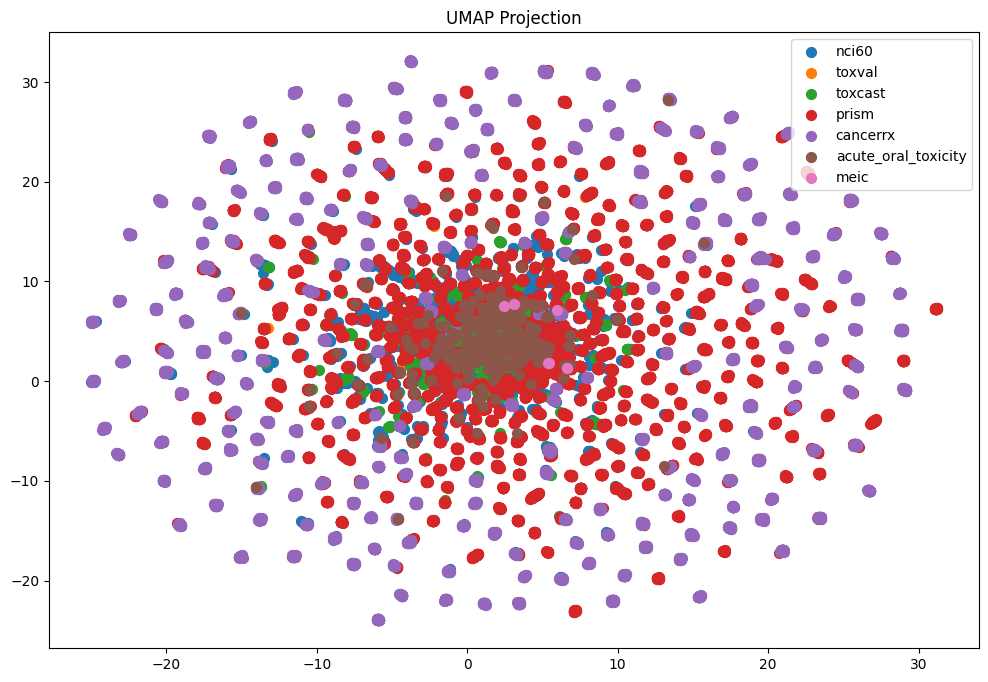

In [26]:
# Create a dictionary to map source_id to colors
color_dict = {"nci60":0, "toxval":1, "toxcast":2, "prism":3, "cancerrx":4, "acute_oral_toxicity":5, "meic":6}

# Apply UMAP
data = feature_df.values
reducer = umap.UMAP(n_components=2, metric='jaccard', n_neighbors=25, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(data)

# Convert the transformed data into a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Reset the index of sampled_df before assigning
embedding_df['source_id'] = sampled_df['source_id'].reset_index(drop=True)

# Create the scatterplot
plt.figure(figsize=(12,8))
for source_id, color in color_dict.items():
    indices_to_keep = embedding_df['source_id'] == source_id
    plt.scatter(
        embedding_df.loc[indices_to_keep, 'UMAP1'],
        embedding_df.loc[indices_to_keep, 'UMAP2'],
        c = sns.color_palette()[color],
        s = 50,
        label = source_id
    )

# Add a title and a legend
plt.title('UMAP Projection')
plt.legend()

# Display the plot
plt.show()


# UMAP for Chemberta embeddings

In [ ]:
RUN_DIR = '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-31/14-49-41'
run_dirs = os.listdir(RUN_DIR)
ecfp4_feature_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/feature/chemberta_1024.parquet" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"])]
ecfp4_feature_dirs = [run_dir for run_dir in ecfp4_feature_dirs if 'ecfp4_1024' not in run_dir]

In [ ]:
ecfp4_assay_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/assay" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"]) and ('ecfp4_1024' not in run_dir)]

In [ ]:
con = duckdb.connect()

dfs = []

for assay_dir, feature_dir in zip(ecfp4_assay_dirs, ecfp4_feature_dirs):
    query = f"""
    SELECT *
    FROM read_parquet('{assay_dir}/*') as A
    JOIN read_parquet('{feature_dir}') as B ON A.canonical_smiles = B.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)
    
full_df = pd.concat(dfs)

In [ ]:
full_df.head()

In [ ]:
# Conduct stratified subsampling on full_df
sampled_df = full_df.groupby('source_id').apply(lambda x: x.sample(frac=0.05))

In [ ]:
feature_df = sampled_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])

In [ ]:
# Create a dictionary to map source_id to colors
color_dict = {"nci60":0, "toxval":1, "toxcast":2, "prism":3, "cancerrx":4, "acute_oral_toxicity":5, "meic":6}

# Apply UMAP
data = feature_df.values
reducer = umap.UMAP(n_components=2, metric='jaccard', n_neighbors=25, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(data)

# Convert the transformed data into a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['source_id'] = sampled_df['source_id']

# Create the scatterplot
plt.figure(figsize=(12,8))
for source_id, color in color_dict.items():
    indices_to_keep = embedding_df['source_id'] == source_id
    plt.scatter(
        embedding_df.loc[:, 'UMAP1'],
        embedding_df.loc[:, 'UMAP2'],
        c = sns.color_palette()[color],
        s = 50,
        label = source_id
    )

# Add a title and a legend
plt.title('UMAP Projection')
plt.legend()

# Display the plot
plt.show()
